In [1]:
#-----------------------------------------------------------------------------------------------------------------
# Simulation experiment
#
# Network:
# A --> gene set C
#
# Algorithm
# Let gene A and B be TF's:
# if gene A expression > threshold_A:
#     genes in set C are upregulated by some percentage of its original expression
#
# Apply this algorithm for each sample in the compendium (essentially adding a signal to the existing gene expression data in the compendium)
# 
# Hyperparmeters should include: 
# 1. Gene A
# 2. Size of gene sets C
# 3. Thresholds
# 4. Percentage to 1.0 (effect size)
# 5. Log file with hyperparameter selections
#-----------------------------------------------------------------------------------------------------------------
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import seaborn as sns

from functions import generate_input, vae, def_offset, interpolate, pca, plot

from numpy.random import seed
randomState = 5
seed(randomState)

Using TensorFlow backend.


In [2]:
# Hyperparameters

# Transcription factors
# If empty, genes will be randomly assigned
geneA = ''

# Size of the gene set that will be regulated by gene A
geneSetC_size = 1000 

# Threshold for activation of gene A 
thresholdA = 0.5

# Amount that genes in gene sets C 
effect_sizeA = 0.5

# Name of analysis
analysis_name = 'sim_nonlin_test'

In [3]:
# Load arguments
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", "all-pseudomonas-gene-normalized.zip")

In [4]:
# Read in data
data = pd.read_table(data_file, header=0, sep='\t', index_col=0, compression='zip').T
data.head(5)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,0.472897,0.396658,0.253776,0.000000,0.175640,0.554385,0.411370,0.382222,0.310144,0.642522,...,0.358597,0.390048,0.457406,0.684082,0.338351,0.608325,0.643496,0.276075,0.112773,0.145170
0.1_2hr_CSV86(Pae_G1a).CEL,0.262346,0.086216,0.359853,0.439214,0.269749,0.768433,0.212505,0.062043,0.567695,0.467073,...,0.358504,0.414206,0.389879,0.477693,0.000000,0.479385,0.154471,0.140891,0.167505,0.157060
0.1_6hr_CSV86(Pae_G1a).CEL,0.473658,0.244862,0.330750,0.097697,0.387226,0.328319,0.228820,0.330039,0.318081,0.512864,...,0.180744,0.380741,0.173501,0.251571,0.182793,0.528301,0.504985,0.499782,0.061106,0.365612
0.1_7hr_CSV86(Pae_G1a).CEL,0.439273,0.343402,0.192698,0.274677,0.628979,0.553796,0.431391,0.363480,0.385721,0.094584,...,0.346837,0.153927,0.067349,0.319723,0.282442,0.490655,0.531415,0.153880,0.132333,0.260087
0.1_9hr_CSV86(Pae_G1a).CEL,0.220827,0.145525,0.437803,0.293201,0.635120,0.462893,0.488733,0.309584,0.318646,0.591914,...,0.237726,0.301945,0.070222,0.513605,0.114277,0.360259,0.386868,0.223995,0.105343,0.102088


In [5]:
# Randomly select gene A if not specified
# Note: 'replace=False' indicates sampling WITHOUT replacement
if not geneA:
    gene_ids = list(data.columns)
    [geneA] = np.random.choice(gene_ids, size=1, replace=False)

print(geneA)

PA2845


In [6]:
# checkpoint
assert(len(gene_ids)==5549)

In [7]:
# Randomly select genes for gene set C
# remove() doesn't return a value it will remove the element from the list object
gene_ids.remove(geneA)
print(len(gene_ids))

# Random sample of genes for set C
geneSetC = random.sample(gene_ids, geneSetC_size)

print(len(geneSetC))

5548
1000


In [8]:
# checkpoint
assert(geneA not in geneSetC)

In [9]:
# checkpoint
# print(data[geneA])

In [10]:
# checkpoint: before transformation
# data.loc[data[geneA]<=thresholdA,geneSetC[0]]

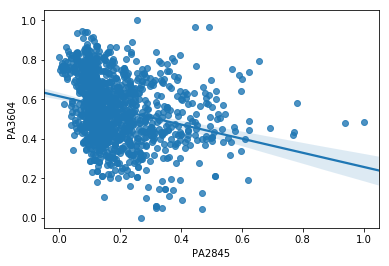

In [11]:
# checkpoint
# plot expression of select gene C across all samples BEFORE transformation

# Randomly from gene set C
geneC = random.sample(geneSetC, 1)[0]

# Dataframe with only gene C and only gene A
geneC_only = pd.DataFrame(data[geneC], index=data.index, columns=[geneC])
geneA_only = pd.DataFrame(data[geneA], index=data.index, columns=[geneA])

# Join 
X = pd.merge(geneA_only, geneC_only, left_index=True, right_index=True)

# Plot
sns.regplot(x=geneA, y=geneC, data=X, scatter=True)

In [12]:
# Loop through all samples
num_samples = data.shape[1]

for sample_id in data.index:
    row = data.loc[sample_id]
        
    if data.loc[sample_id,geneA] > thresholdA:
        # Scale genes by some fixed percentage
        for gene in geneSetC:
            data.loc[sample_id,gene] = data.loc[sample_id,gene]*(1+effect_sizeA)            
            
# if any exceed 1 then set to 1 since gene expression is normalized
data[data>=1.0] = 1.0

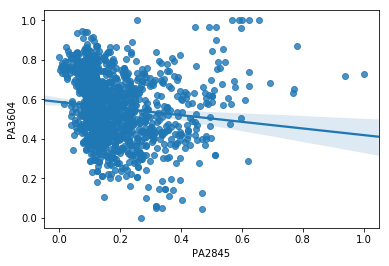

In [13]:
# checkpoint
# plot expression of select gene C across all samples AFTER transformation

# Dataframe with only gene C and only gene A
geneC_only = pd.DataFrame(data[geneC], index=data.index, columns=[geneC])
geneA_only = pd.DataFrame(data[geneA], index=data.index, columns=[geneA])

# Join 
X = pd.merge(geneA_only, geneC_only, left_index=True, right_index=True)

# Plot
sns.regplot(x=geneA, y=geneC, data=X, scatter=True)

In [14]:
# checkpoint: after transformation
# data.loc[data[geneA]<=thresholdA,geneSetC[0]]

In [15]:
# Dataframe with only gene A
geneA_only = pd.DataFrame(data[geneA], index=data.index, columns=[geneA])

# Drop gene A
data_holdout = data.drop(columns=[geneA])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd940f0cc88>]], dtype=object)

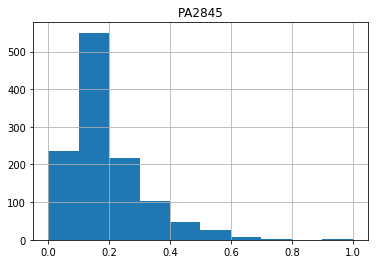

In [16]:
# checkpoint
# plot distribution of gene A
geneA_only.hist()

In [17]:
# checkpoint
data_holdout.shape

(1191, 5548)

In [18]:
# Create list of base directories
base_dirs = [os.path.join(os.path.dirname(os.getcwd()), 'data'),
             os.path.join(os.path.dirname(os.getcwd()), 'encoded'),
             os.path.join(os.path.dirname(os.getcwd()), 'models'),
             os.path.join(os.path.dirname(os.getcwd()), 'output'),
             os.path.join(os.path.dirname(os.getcwd()), 'stats'),
             os.path.join(os.path.dirname(os.getcwd()), 'viz')    
]

# Check if directory exist otherwise create
for each_dir in base_dirs:
    analysis_dir = os.path.join(each_dir, analysis_name)
    if os.path.exists(analysis_dir):
        print('directory already exists: {}'.format(analysis_dir))
    else:
        os.mkdir(analysis_dir)
        print('creating new directory: {}'.format(analysis_dir))

creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/data/sim_nonlin_test
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/encoded/sim_nonlin_test
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/models/sim_nonlin_test
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/output/sim_nonlin_test
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/stats/sim_nonlin_test
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/viz/sim_nonlin_test


In [19]:
# Output the new gene expression values for each sample
train_input_file = os.path.join(base_dirs[0], analysis_name, "train_model_input.txt.xz")
data_holdout.to_csv(train_input_file, sep='\t', compression='xz', float_format="%.5g")

# Output log file with params
log_file = os.path.join(os.path.dirname(os.getcwd()), 'metadata', analysis_name + '.txt')

args_dict = {
    "gene A": geneA,
    "size of gene set C": geneSetC_size,
    "genes in set C": geneSetC,
    "threshold of A activation": thresholdA,
    "effect size of genes in set C": effect_sizeA,
}

with open(log_file, 'w') as f:
    for key, value in args_dict.items():
        f.write('%s: %s\n' % (key, value))
        
# Output geneA only file
geneA_file = os.path.join(base_dirs[0], analysis_name, geneA + ".txt")
geneA_only.to_csv(geneA_file, sep='\t', float_format="%.5g")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.58 µs


/home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/scripts/functions/vae.py:196: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  vae.compile(optimizer=adam, loss=None, loss_weights=[beta])


Train on 1072 samples, validate on 119 samples
Epoch 1/200
1072/1072 [==============================] - 1s 1ms/step - loss: 3755.4357 - val_loss: 3611.3997
Epoch 2/200
1072/1072 [==============================] - 1s 876us/step - loss: 3598.7663 - val_loss: 3619.2547
Epoch 3/200
1072/1072 [==============================] - 1s 898us/step - loss: 3526.5488 - val_loss: 3599.1968
Epoch 4/200
1072/1072 [==============================] - 1s 928us/step - loss: 3499.9390 - val_loss: 3591.6405
Epoch 5/200
1072/1072 [==============================] - 1s 891us/step - loss: 3486.9377 - val_loss: 3557.0032
Epoch 6/200
1072/1072 [==============================] - 1s 967us/step - loss: 3479.5847 - val_loss: 3525.7684
Epoch 7/200
1072/1072 [==============================] - 1s 964us/step - loss: 3475.4874 - val_loss: 3505.7994
Epoch 8/200
1072/1072 [==============================] - 1s 926us/step - loss: 3468.6892 - val_loss: 3496.0720
Epoch 9/200
1072/1072 [==============================] - 1s 908us/s

Epoch 74/200
1072/1072 [==============================] - 1s 872us/step - loss: 3388.2151 - val_loss: 3406.6244
Epoch 75/200
1072/1072 [==============================] - 1s 875us/step - loss: 3389.7727 - val_loss: 3409.0045
Epoch 76/200
1072/1072 [==============================] - 1s 880us/step - loss: 3388.0508 - val_loss: 3408.1929
Epoch 77/200
1072/1072 [==============================] - 1s 911us/step - loss: 3386.5176 - val_loss: 3407.2638
Epoch 78/200
1072/1072 [==============================] - 1s 920us/step - loss: 3386.1856 - val_loss: 3404.0647
Epoch 79/200
1072/1072 [==============================] - 1s 861us/step - loss: 3383.5433 - val_loss: 3402.9806
Epoch 80/200
1072/1072 [==============================] - 1s 868us/step - loss: 3384.2421 - val_loss: 3400.5397
Epoch 81/200
1072/1072 [==============================] - 1s 931us/step - loss: 3383.9124 - val_loss: 3403.8355
Epoch 82/200
1072/1072 [==============================] - 1s 892us/step - loss: 3383.8490 - val_loss: 34

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Number of genes in low expression group is (60, 5548)
Number of gene in high expression group is (61, 5548)
Number of genes in low expression group is (60, 5548)
Number of gene in high expression group is (61, 5548)


/home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/scripts/functions/plot.py:87: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X_sorted = X.loc[sorted_id.index].dropna()


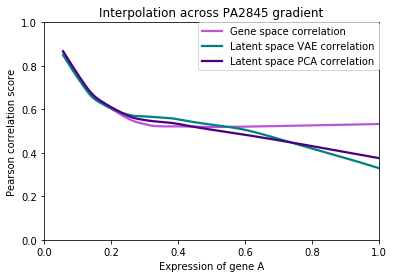

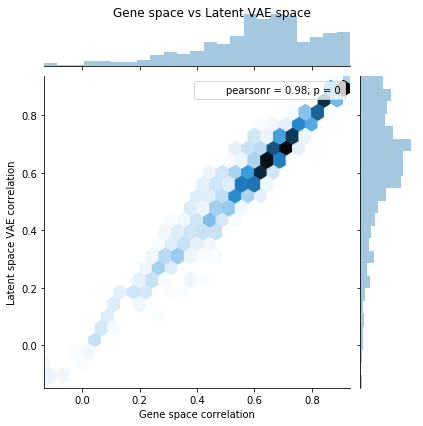

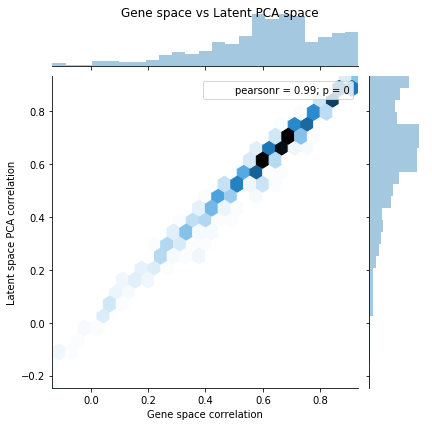

In [20]:
%time

# Train models on input dataset

# params
learning_rate = 0.001
batch_size = 100
epochs = 200
kappa = 0.01
intermediate_dim = 100
latent_dim = 10
epsilon_std = 1.0
num_PCs = latent_dim

base_dir = os.path.dirname(os.getcwd())
vae.tybalt_2layer_model(learning_rate, batch_size, epochs, kappa, intermediate_dim,
                        latent_dim, epsilon_std, base_dir, analysis_name)
pca.pca_model(base_dir, analysis_name, num_PCs)


# Define offset vectors in gene space
data_dir = os.path.join(base_dirs[0], analysis_name)
target_gene = geneA
percent_low = 5
percent_high = 95

def_offset.gene_space_offset(data_dir, target_gene, percent_low, percent_high)


# Define offset vectors for different latent spaces
model_dir = os.path.join(base_dirs[2], analysis_name)
encoded_dir = os.path.join(base_dirs[1], analysis_name)

def_offset.vae_latent_space_offset(data_dir, model_dir, encoded_dir, target_gene, percent_low, percent_high)
def_offset.pca_latent_space_offset(data_dir, model_dir, encoded_dir, target_gene, percent_low, percent_high)


# Predict gene expression using offset in gene space and latent space
out_dir = os.path.join(base_dirs[3], analysis_name)

interpolate.interpolate_in_gene_space(data_dir, target_gene, out_dir, percent_low, percent_high)
interpolate.interpolate_in_vae_latent_space(data_dir, model_dir, encoded_dir, target_gene, out_dir, percent_low, percent_high)
interpolate.interpolate_in_pca_latent_space(data_dir, model_dir, encoded_dir, target_gene, out_dir, percent_low, percent_high)

# True if the x-axis of the plot uses the sample index
# False if the x-asix of the plot uses the gene expression of the target gene
by_sample_ind = False

# Plot prediction per sample along gradient of PA1673 expression
viz_dir = os.path.join(base_dirs[5], analysis_name)
plot.plot_corr_gradient(out_dir, viz_dir, geneA, by_sample_ind)